# Générer le dataset d'entraînement à partir d'images seules

Cette étape utilise un réseau de neurones de type MiDaS préentraîné pour générer un depth map approximatif des images monoculaires du dataset.

In [1]:
import glob
import cv2

import matplotlib.pyplot as plt

from mono2stereo import Mono2Stereo

## Importer le dataset



In [2]:
# Connecter Google Drive pour accéder aux datasets
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
DATASET_PATH = "/content/drive/MyDrive/datasets/COCO_2017/subset_10/"

dataset = [cv2.imread(file) for file in glob.glob(f"{DATASET_PATH}*.jpg")]
dataset = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in dataset]

In [4]:
dataset[0].shape

(426, 640, 3)

## Générer les depth maps pour le dataset

In [5]:
mono_to_stereo = Mono2Stereo()

Loading weights:  None


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /root/.cache/torch/hub/facebookresearch_WSL-Images_master
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


## Générer les images de droite

In [10]:
results = mono_to_stereo.generate_right_view(dataset, d_max=96)

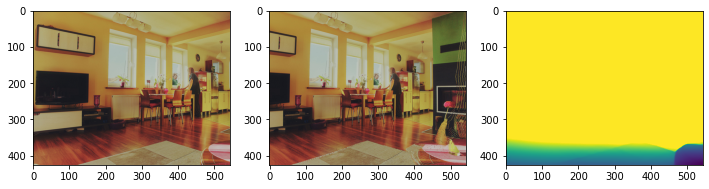

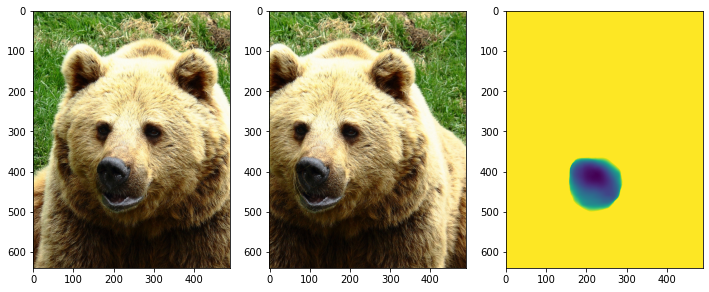

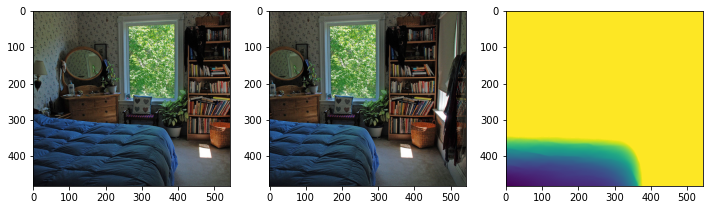

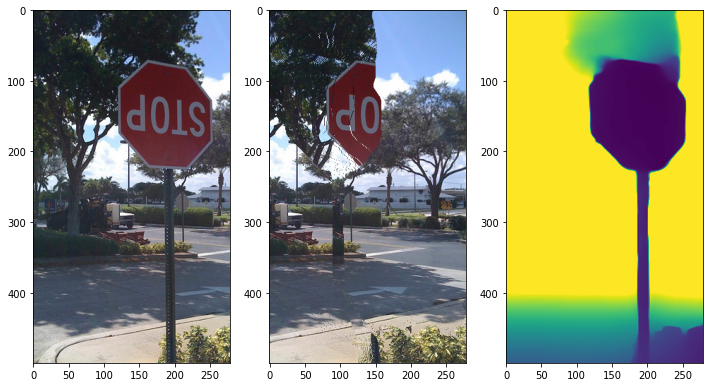

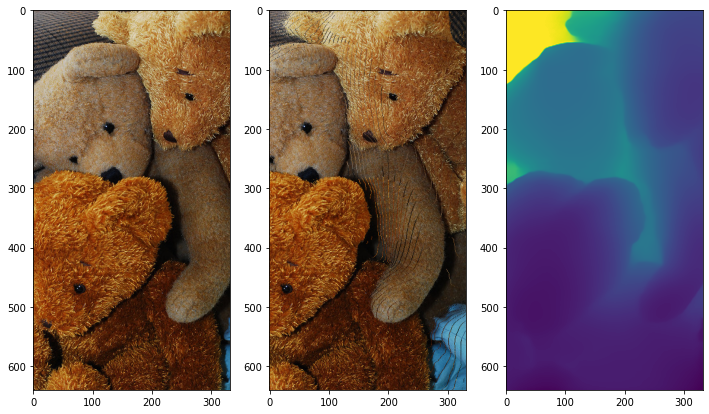

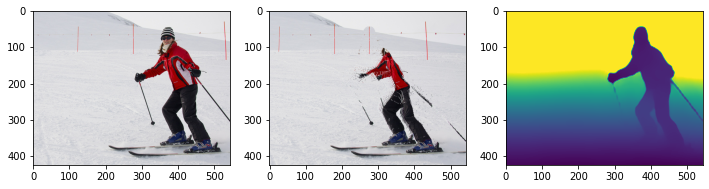

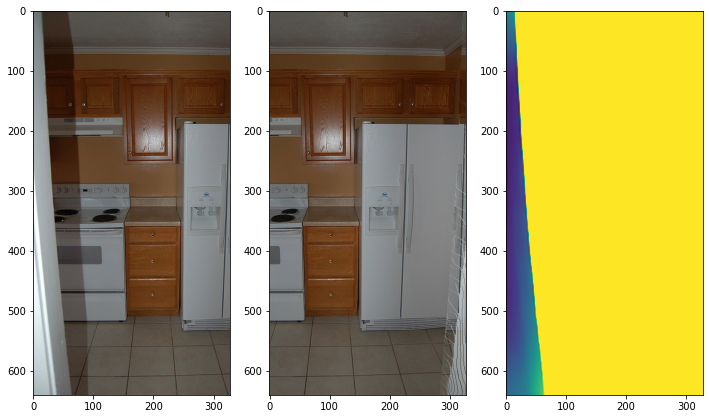

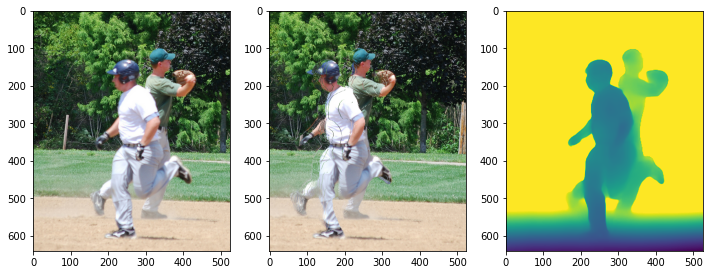

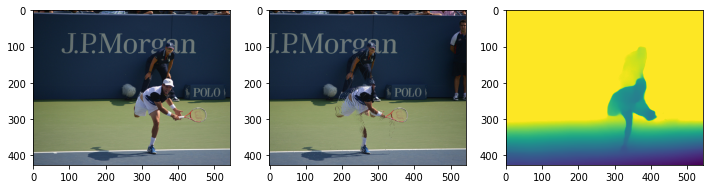

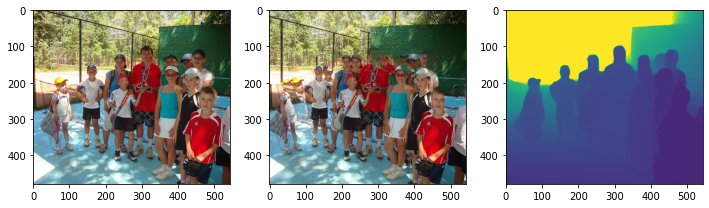

In [11]:
# Test: Compare with original

def display_result(result):
  fig = plt.figure(figsize=(12, 12))

  l_img, r_img, dispmap = result

  fig.add_subplot(1, 3, 1)
  plt.imshow(l_img)
  fig.add_subplot(1, 3, 2)
  plt.imshow(r_img)
  fig.add_subplot(1, 3, 3)
  plt.imshow(dispmap)

  plt.show()

for result in results:
  display_result(result)

## Exporter les images générées

In [9]:
def save_result(result, index):
  left_save_path = "/content/output/left"
  right_save_path = "/content/output/right"
  disp_save_path = "/content/output/disp"

  index = index + 1
  result = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in result]

  l_img, r_img, disp = result

  file_number = str(index).zfill(10)
  filename = f"{file_number}.png"

  cv2.imwrite(left_save_path + "/" + filename, l_img)
  cv2.imwrite(right_save_path + "/" + filename, r_img)
  cv2.imwrite(disp_save_path + "/" + filename, disp)

  print(f"Result {index} saved.")

for index, result in enumerate(results):
  save_result(result, index)

Result 1 saved.
Result 2 saved.
Result 3 saved.
Result 4 saved.
Result 5 saved.
Result 6 saved.
Result 7 saved.
Result 8 saved.
Result 9 saved.
Result 10 saved.
